In [1]:
library(ggplot2)
library(ggpubr)
library(viridis)
library(gridExtra)
library(dplyr)
library(data.table)
library(magrittr)
library(ggpubr)

Loading required package: viridisLite


Attaching package: ‘dplyr’


The following object is masked from ‘package:gridExtra’:

    combine


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last




In [2]:
library(data.table)
library(umap)
library(gridExtra)
library(Rtsne)
library(mclust)
library(cluster)
library(lisi)
library(stringr)
library(harmony)
# library(cisTopic)
library(SingleCellExperiment)
library(Seurat)
library(pdfCluster)
require(RANN)
# library(kBET)

mlgFindNeighbors = function(latent){
  rownames(latent) = paste0("cell", 1:nrow(latent))
  NN_graph = FindNeighbors(latent, verbose = FALSE, nn.method = "rann")
  G = NN_graph$snn
  return(G)
}
mlgARI = function(embed, summary){
    cluster = summary$celltype
    clusterN = length(unique(cluster))
    G = mlgFindNeighbors(embed)
    l = 0.1
    h = 2
    iter = 1
    while (l < h) {
    mid = l + (h - l) / 2
    mlgc = try(FindClusters(G, resolution = mid, random.seed = 2020, verbose = FALSE)[[1]])
    if(class(mlgc) == "try-error"){
        h = mid
    }else{
        nml = length(unique(mlgc))
        if (nml == clusterN) break
        if (iter > 40) {
        print("not arrive")
            break
        }
        if (nml < clusterN) l = mid
        else h = mid
    }
    iter = iter + 1
    }
    mlgARI = adj.rand.index(mlgc, cluster)
    return(mlgARI)
}
evaluation_func = function(embed, summary, mlgARI = TRUE){
    summary$celltype = as.factor(summary$celltype)
    umap_out = umap(embed)
    tsne_out = Rtsne(embed)
    num_centers = length(unique(summary$celltype))
    kmeansRES = kmeans(embed, centers = num_centers, nstart = 100, iter.max = 100)$cluster
    kmeansRESumap = kmeans(umap_out$layout, centers = num_centers,  iter.max = 100, nstart = 100)$cluster
    kmeansREStsne = kmeans(tsne_out$Y, centers = num_centers,  iter.max = 100, nstart = 100)$cluster
    if(mlgARI){
    return(data.frame(metric = c("Silhouette score + tSNE", "Silhouette score + UMAP",
                                "ARI + Embedding", "ARI + UMAP", "ARI + tSNE", "Batch ARI",
                                 "MLG ARI"),
        score = c(mean(silhouette(as.numeric(as.factor(summary$celltype)), dist(data.frame(tsne_out$Y)))[, 3]),
                    mean(silhouette(as.numeric(as.factor(summary$celltype)), dist(data.frame(umap_out$layout)))[, 3]),
                    adjustedRandIndex(kmeansRES, summary$celltype),
                    adjustedRandIndex(kmeansRESumap, summary$celltype),
                    adjustedRandIndex(kmeansREStsne, summary$celltype),
                    ifelse("batch" %in% colnames(summary), adjustedRandIndex(kmeansRES, summary$batch), NA),
                    mlgARI(embed, summary))))
        
    }else{
    return(data.frame(metric = c("Silhouette score + tSNE", "Silhouette score + UMAP",
                                "ARI + Embedding", "ARI + UMAP", "ARI + tSNE", "Batch ARI"),
        score = c(mean(silhouette(as.numeric(as.factor(summary$celltype)), dist(data.frame(tsne_out$Y)))[, 3]),
                    mean(silhouette(as.numeric(as.factor(summary$celltype)), dist(data.frame(umap_out$layout)))[, 3]),
                    adjustedRandIndex(kmeansRES, summary$celltype),
                    adjustedRandIndex(kmeansRESumap, summary$celltype),
                    adjustedRandIndex(kmeansREStsne, summary$celltype),
                    ifelse("batch" %in% colnames(summary), adjustedRandIndex(kmeansRES, summary$batch), NA))))
        
    }
}
evaluationLISI = function(embed, summary){
    if ("batch" %in% colnames(summary)) {
        return(compute_lisi(embed, summary, 'batch')$batch)
    } else {
        return(rep(NA, nrow(summary)))
    }
}

Package 'mclust' version 5.4.7
Type 'citation("mclust")' for citing this R package in publications.

Loading required package: Rcpp

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘matrixStats’


The following object is masked from ‘package:dplyr’:

    count



Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowColla

# metric heatmap

In [ ]:
metric = fread("/CSV/metrics.txt", sep = "\t", header = T, fill = T)
metric3DVI = fread("/CSV/metrics_3DVI.txt", sep = "\t", header = T, fill = T)
metric = cbind(metric, metric3DVI[, 2:ncol(metric3DVI)])
info = strsplit(colnames(metric)[2:ncol(metric)] %>% tolower, "_")

In [14]:
metricD = c()
scoreInd = 2:ncol(metric)
scoreInd = scoreInd[!scoreInd %in% rmInd]
for(j in 1:nrow(metric)){
    metricD = data.frame(dataSource = metric$dataSource[j], score = as.matrix(metric)[j, scoreInd]) %>% cbind(mInfo) %>% rbind(metricD, .)
}
metricD$dataSource = factor(metricD$dataSource, levels = c('Ramani', 'Lee', 'Li', 'Kim'), labels = c('Ramani2017', 'Lee2019', 'Li2019', 'Kim2020'))
metricD$score = as.numeric(as.vector(metricD$score))
metricD %>% head

,dataSource,score,method,evaluation,embedding
,<fct>,<dbl>,<fct>,<fct>,<fct>
raw_silhouette_tsne,Kim2020,0.1178814800,RawCount,Silhouette Score,t-SNE Embeddings
raw_silhouette_umap,Kim2020,0.1300051300,RawCount,Silhouette Score,UMAP Embeddings
raw_ARI_embed,Kim2020,-0.0007758046,RawCount,K-means ARI,Method Embeddings
raw_ARI_umap,Kim2020,0.2802253000,RawCount,K-means ARI,UMAP Embeddings
raw_ARI_tsne,Kim2020,0.2745947000,RawCount,K-means ARI,t-SNE Embeddings
schicluster_silhouette_tsne,Kim2020,0.3002486400,scHiCluster,Silhouette Score,t-SNE Embeddings


In [16]:
metricD_final = metricD %>% filter(method %in% c('CellScale','BandScale', 'BandNorm', 'scHiCluster', 'scHiC Topics', 
                                 'Higashi', 'BandScale+CNN', 'scVI-3D'))

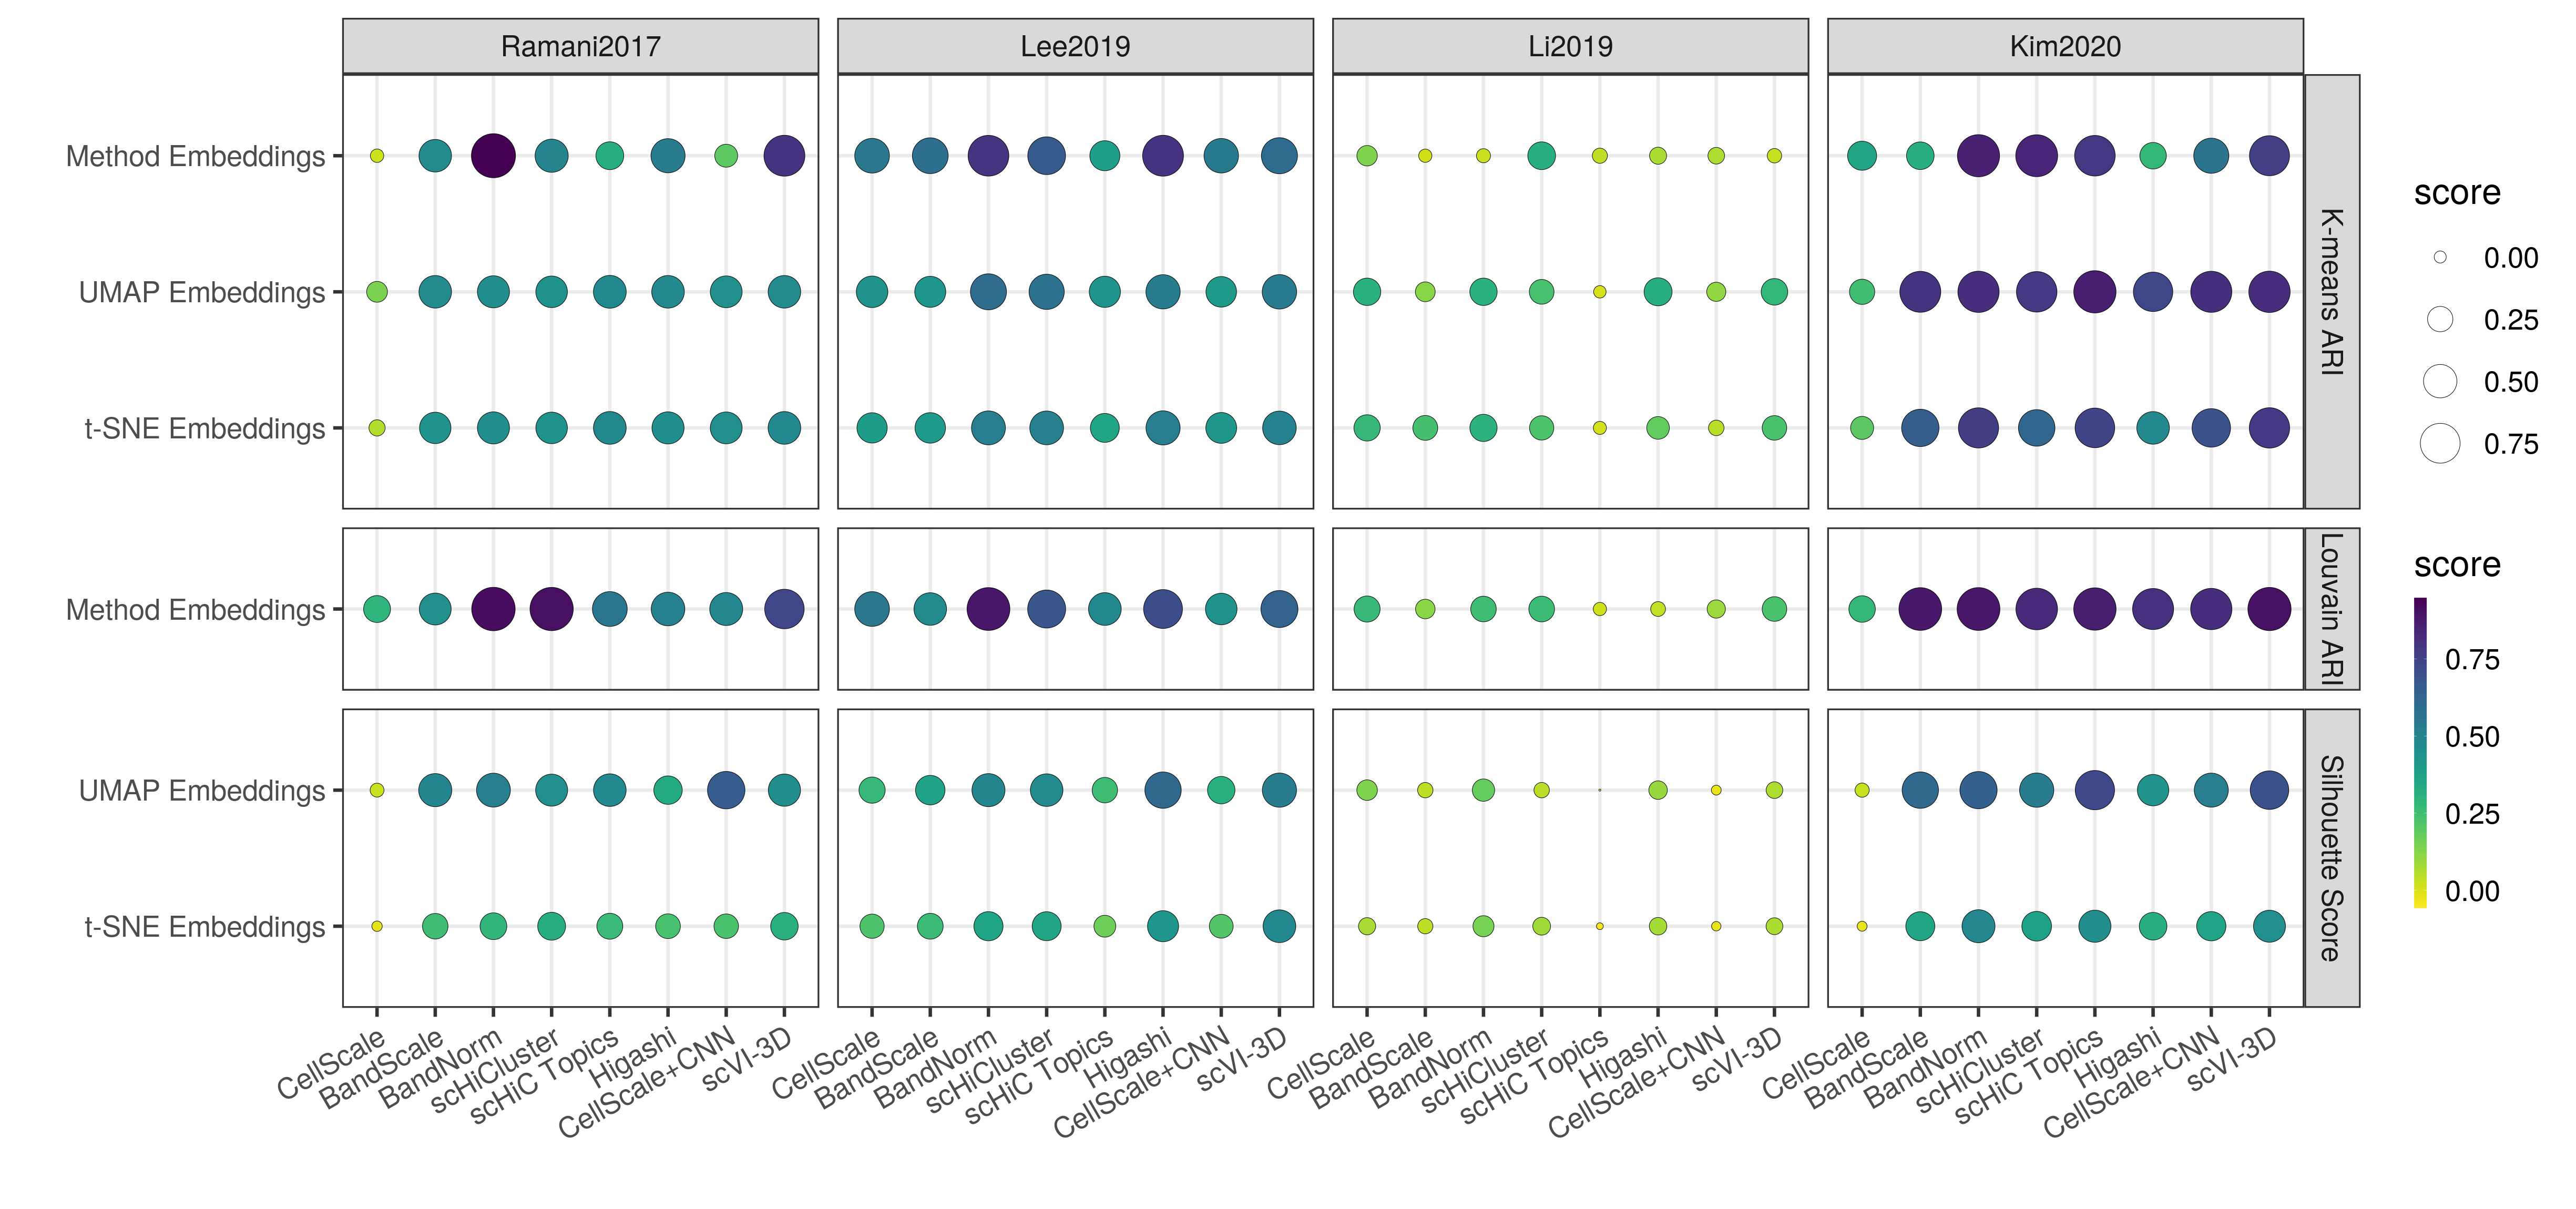

In [30]:
options(repr.plot.width = 49, repr.plot.height = 23, repr.plot.res = 100)

p1D = metricD_final %>% filter(evaluation != "Batch ARI") %>%
        ggplot(aes(y = embedding, x = method, fill = score)) +
        geom_point(aes(size = score), shape = 21) +
        scale_size_continuous(range = c(1, 28)) +
        theme_bw(base_size = 49) +
        scale_fill_viridis(option = "viridis", begin = 1, end = 0) +
        #scale_fill_distiller(palette = "YlGnBu", direction = -1) +
        facet_grid(evaluation~dataSource, scale = "free", space = "free") +
        xlab("") +
        ylab("") +
        ggpubr::rotate_x_text(angle = 30) +
theme(legend.position = "right", legend.key.height = unit(3, "cm"))

p1D

rankD

`summarise()` has grouped output by 'dataSource'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'dataSource'. You can override using the `.groups` argument.



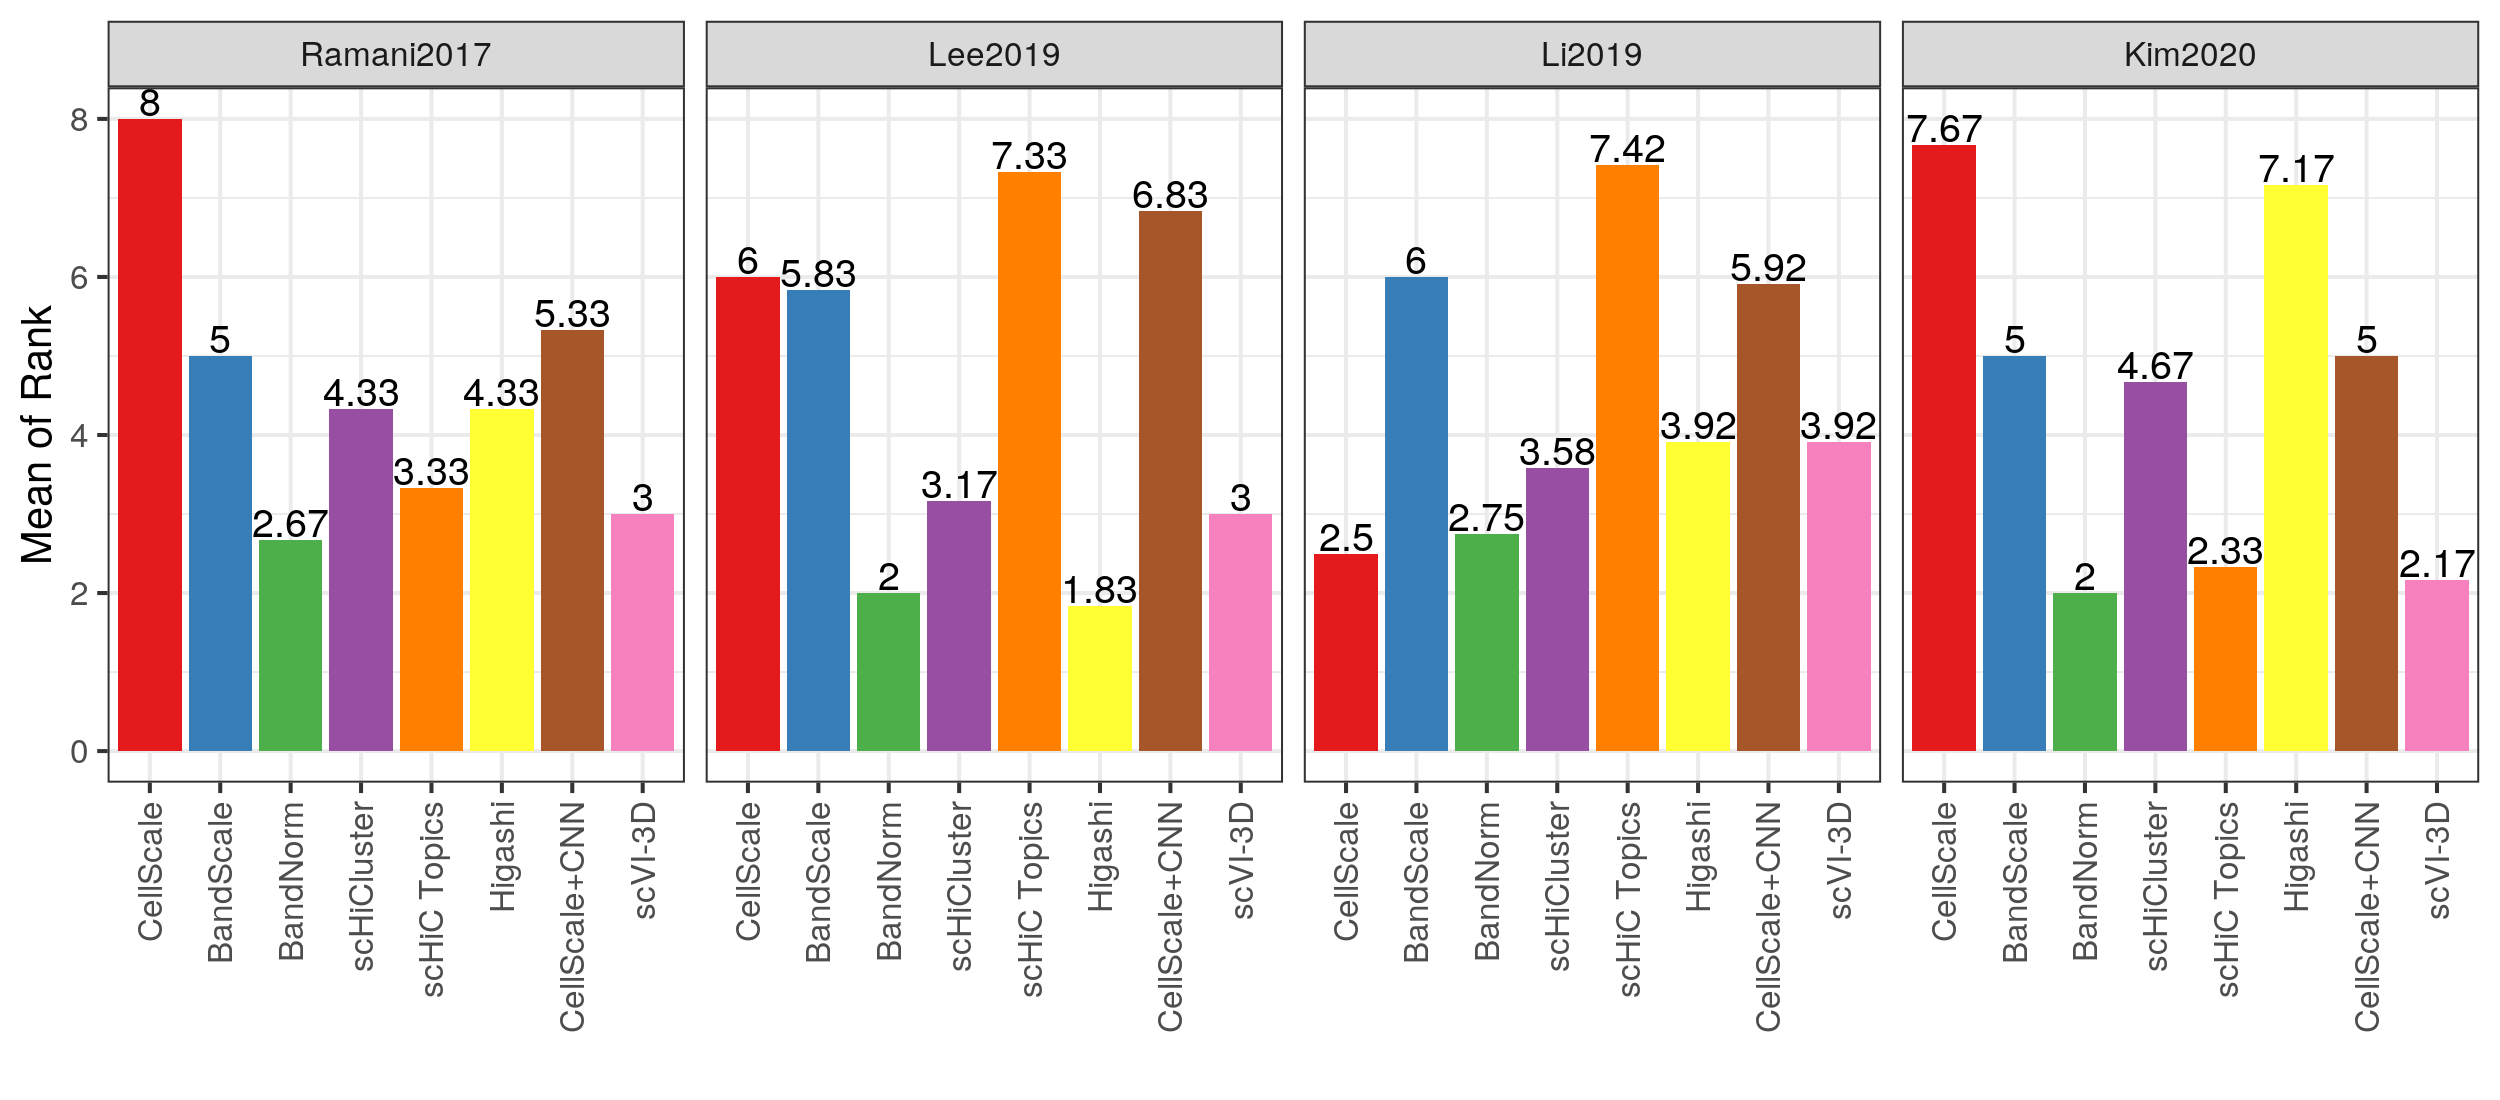

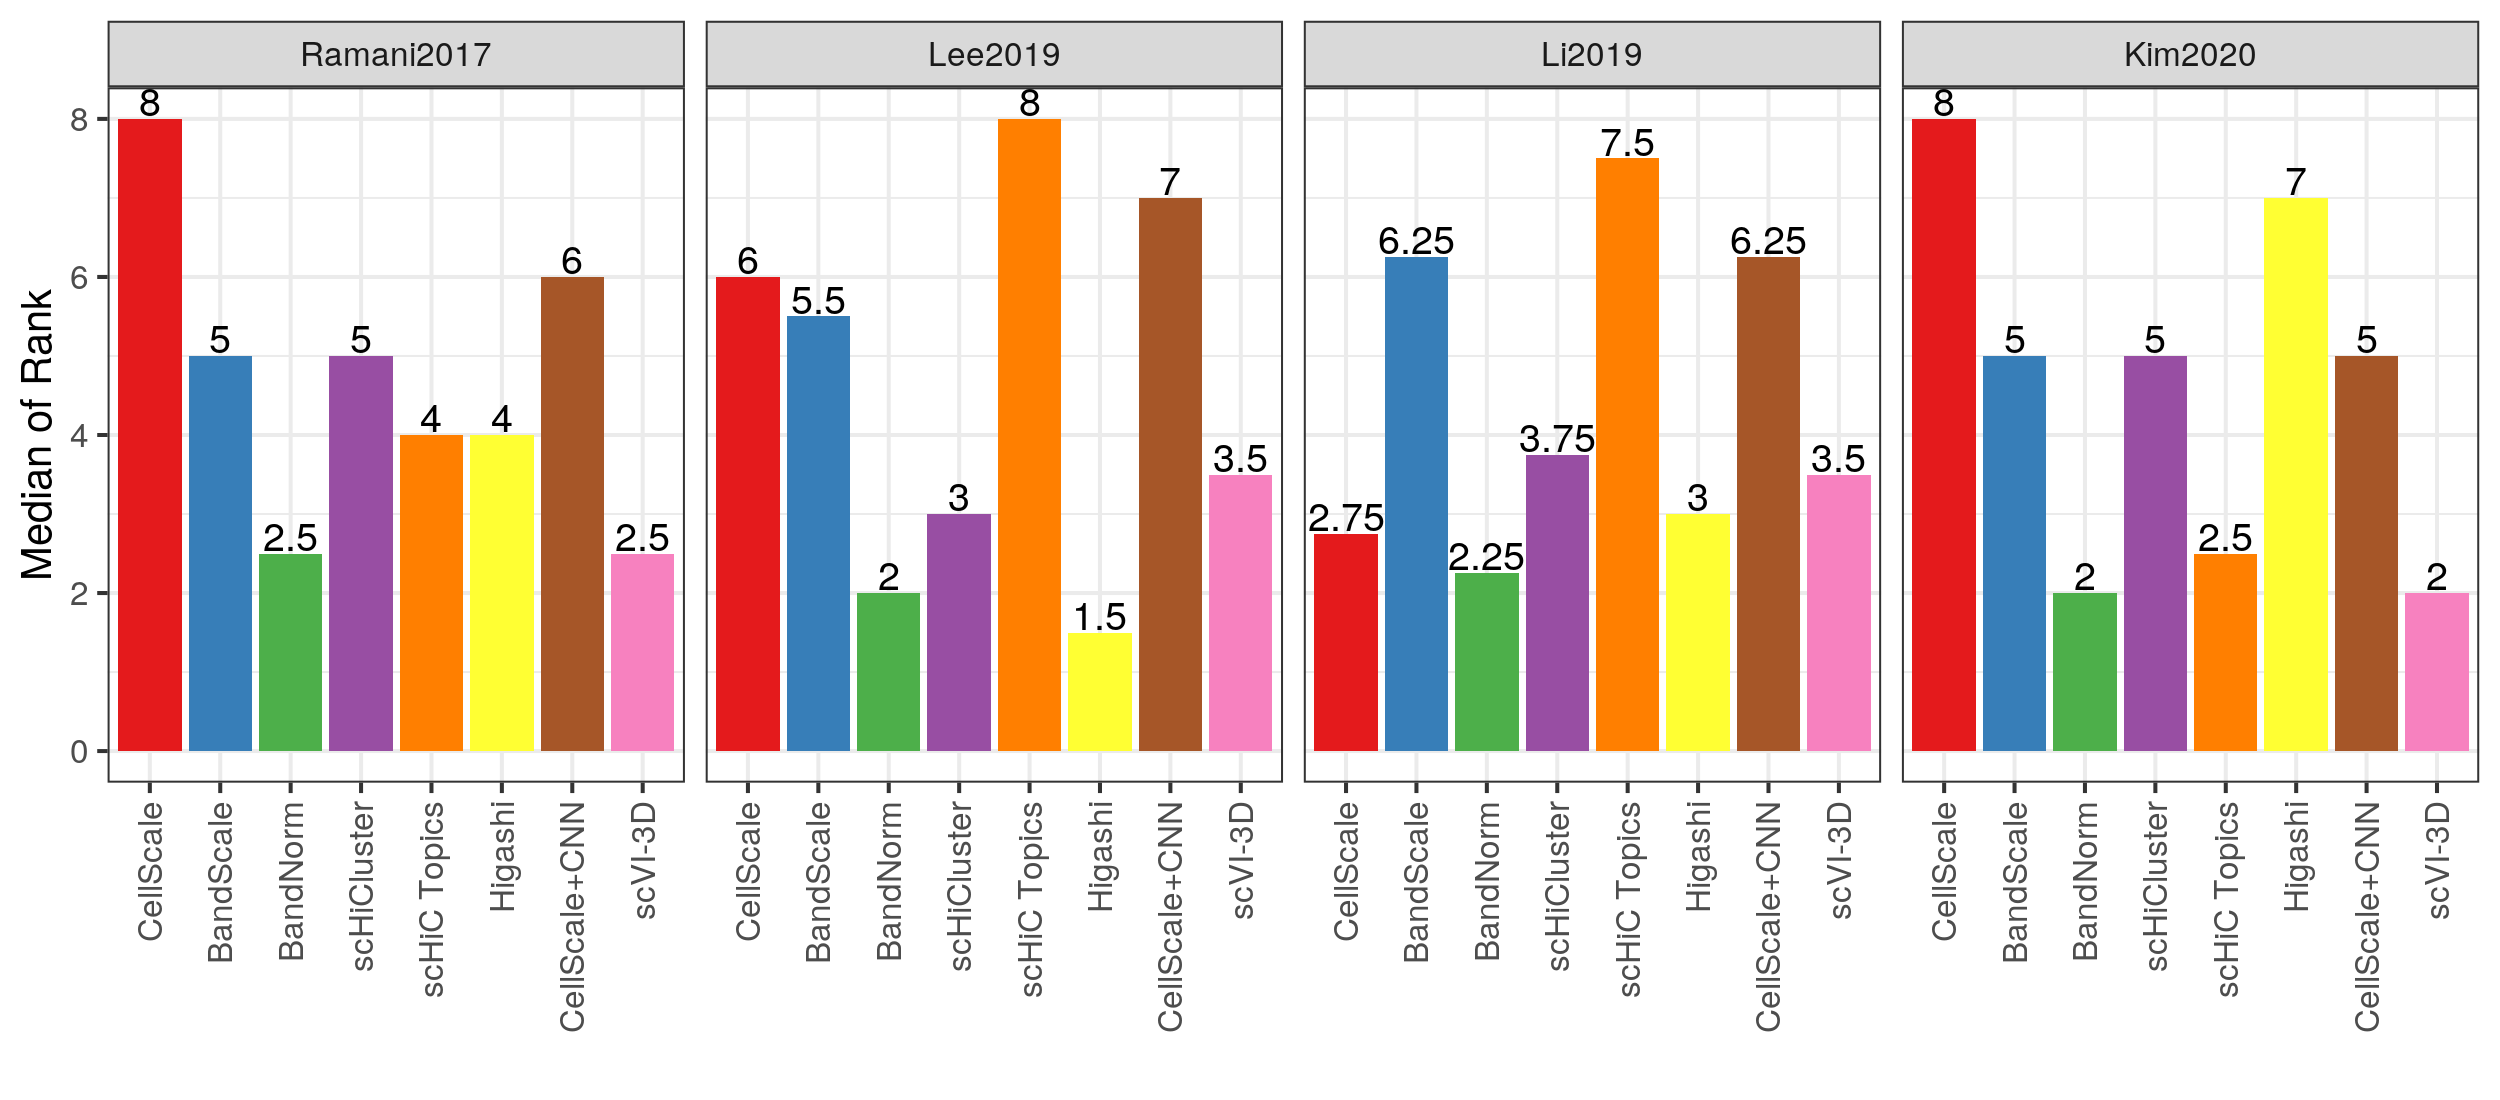

In [33]:
options(repr.plot.width = 25, repr.plot.height = 11, repr.plot.res = 100)
rankD %>% group_by(dataSource, method) %>% summarize(meanRank = mean(rank), medianRank = median(rank)) %>% ggplot(aes(x = method, y = meanRank, fill = method, group = dataSource, label = round(meanRank, 2))) +
geom_bar(stat = "identity", position = position_dodge()) +
facet_grid(~dataSource) +
geom_text(vjust = -0.1, size = 10) +
theme_bw(base_size = 30) +
ggpubr::rremove("legend") +
ggpubr::rotate_x_text(angle = 90) +
scale_fill_brewer(palette = "Set1") +
xlab("") +
ylab("Mean of Rank")

rankD %>% group_by(dataSource, method) %>% summarize(meanRank = mean(rank), medianRank = median(rank)) %>% ggplot(aes(x = method, y = medianRank, fill = method, group = dataSource, label = round(medianRank, 2))) +
geom_bar(stat = "identity", position = position_dodge()) +
facet_grid(~dataSource) +
geom_text(vjust = -0.1, size = 10) +
theme_bw(base_size = 30) +
ggpubr::rremove("legend") +
ggpubr::rotate_x_text(angle = 90) +
scale_fill_brewer(palette = "Set1") +
xlab("") +
ylab("Median of Rank")


,method,meanRank,medianRank
,<fct>,<dbl>,<dbl>
1,CellScale,6.041667,7.00
2,BandScale,5.458333,5.25
3,BandNorm,2.354167,2.00
4,scHiCluster,3.937500,4.00
5,scHiC Topics,5.104167,6.00
6,Higashi,4.312500,3.50
7,CellScale+CNN,5.770833,6.00
8,scVI-3D,3.020833,3.00


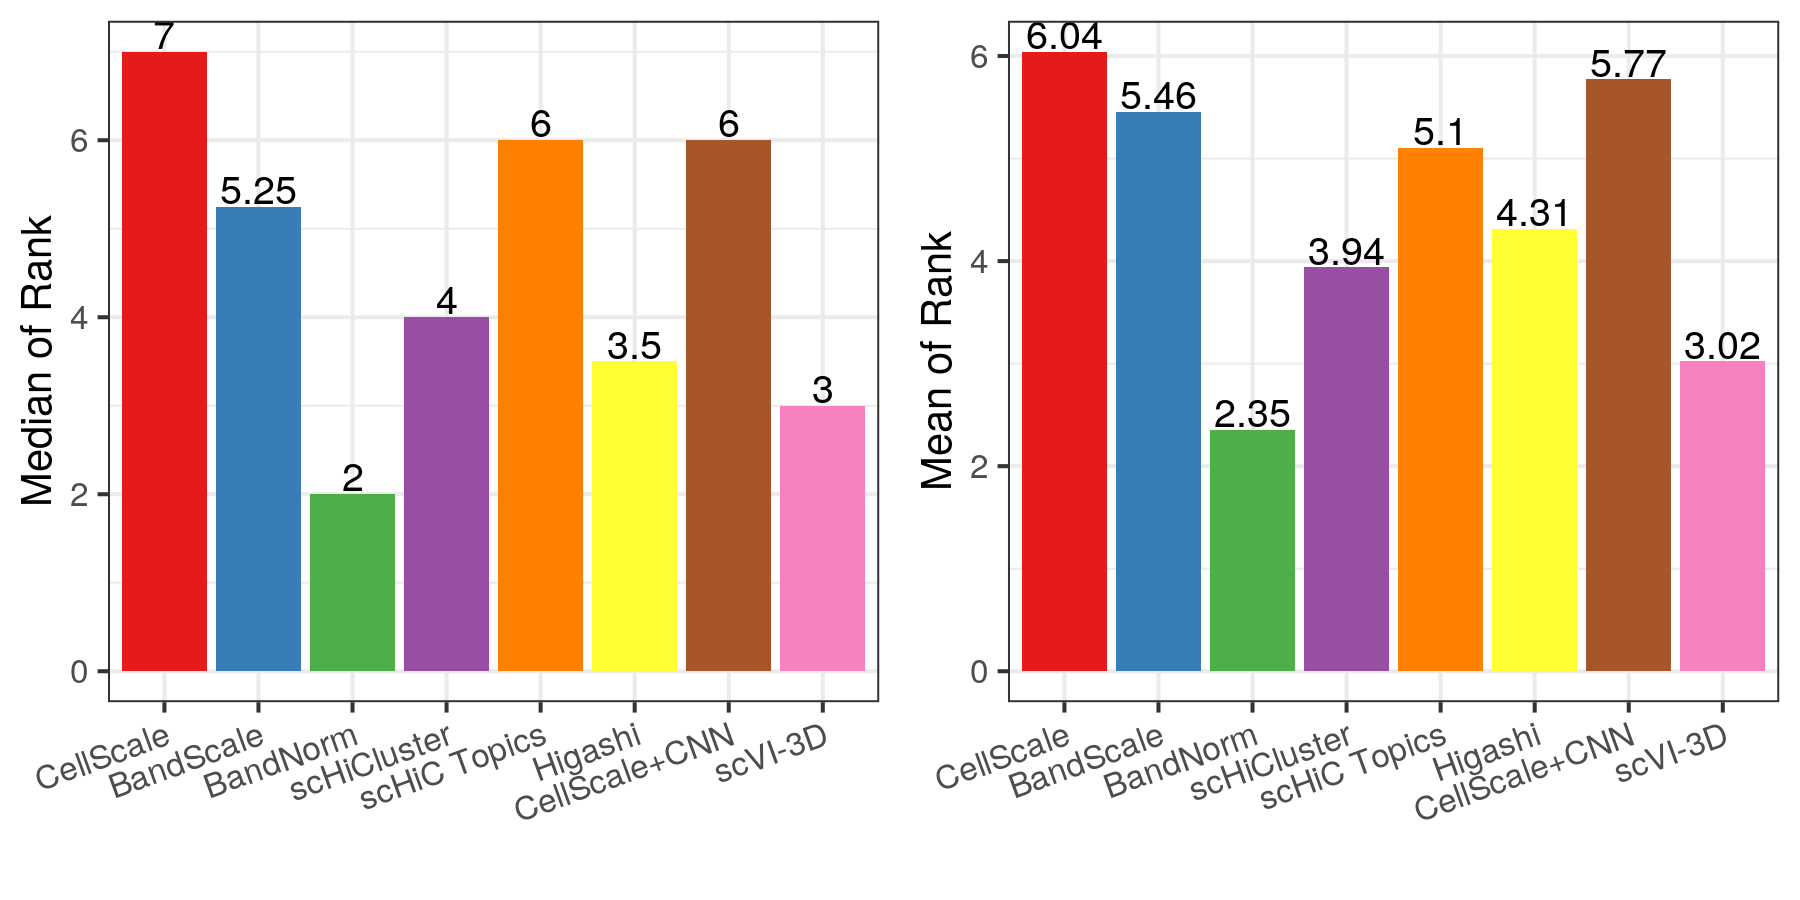

In [34]:
options(repr.plot.width = 18, repr.plot.height = 9, repr.plot.res = 100)
rankSummary = rankD %>% group_by(method) %>% summarize(meanRank = mean(rank), medianRank = median(rank)) # %>% dplyr::filter(dataSource != "Li2019")
rankSummary
p1 = rankSummary %>% ggplot(aes(x = method, y = meanRank, fill = method,  label = round(meanRank, 2))) +
geom_bar(stat = "identity") +
geom_text(vjust = -0.1, size = 10) +
theme_bw(base_size = 30) +
ggpubr::rremove("legend") +
ggpubr::rotate_x_text(angle = 20) +
scale_fill_brewer(palette = "Set1") +
xlab("") +
ylab("Mean of Rank")

p2 = rankSummary %>% ggplot(aes(x = method, y = medianRank, fill = method,  label = round(medianRank, 3))) +
geom_bar(stat = "identity") +
geom_text(vjust = -0.1, size = 10) +
theme_bw(base_size = 30) +
ggpubr::rremove("legend") +
ggpubr::rotate_x_text(angle = 20) +
scale_fill_brewer(palette = "Set1") +
xlab("") +
ylab("Median of Rank")

ggarrange(p2, p1, ncol = 2)

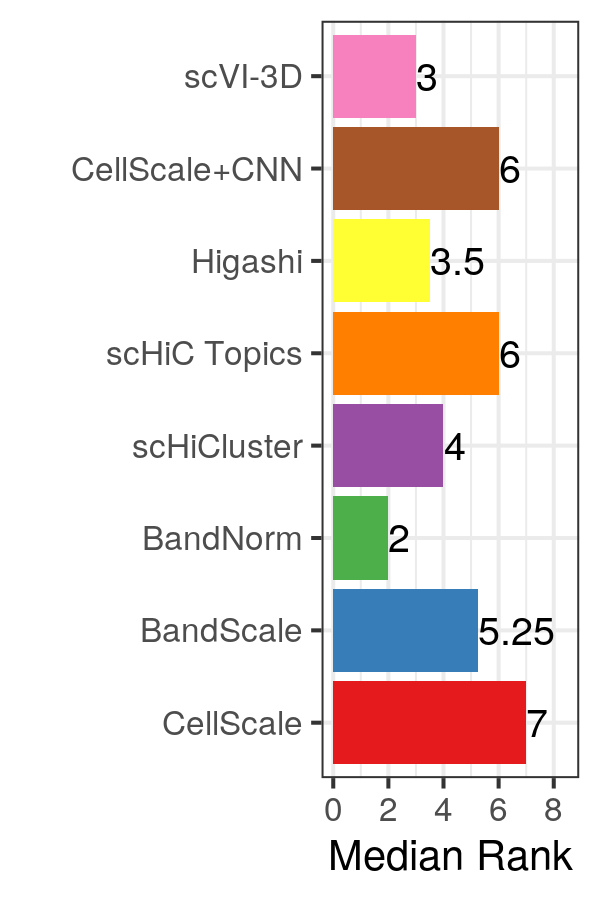

In [36]:
options(repr.plot.width = 6, repr.plot.height = 9, repr.plot.res = 100)
p2 = rankSummary %>% ggplot(aes(x = method, y = medianRank, fill = method,  label = round(medianRank, 2))) +
geom_bar(stat = "identity") +
geom_text(hjust = -0, size = 10) +
theme_bw(base_size = 30) +
ggpubr::rremove("legend") +
ggpubr::rotate_x_text(angle = 0) +
scale_fill_brewer(palette = "Set1") +
xlab("") +
ylab("Median Rank") + 
ylim(0, 8.5) +
coord_flip()
p2

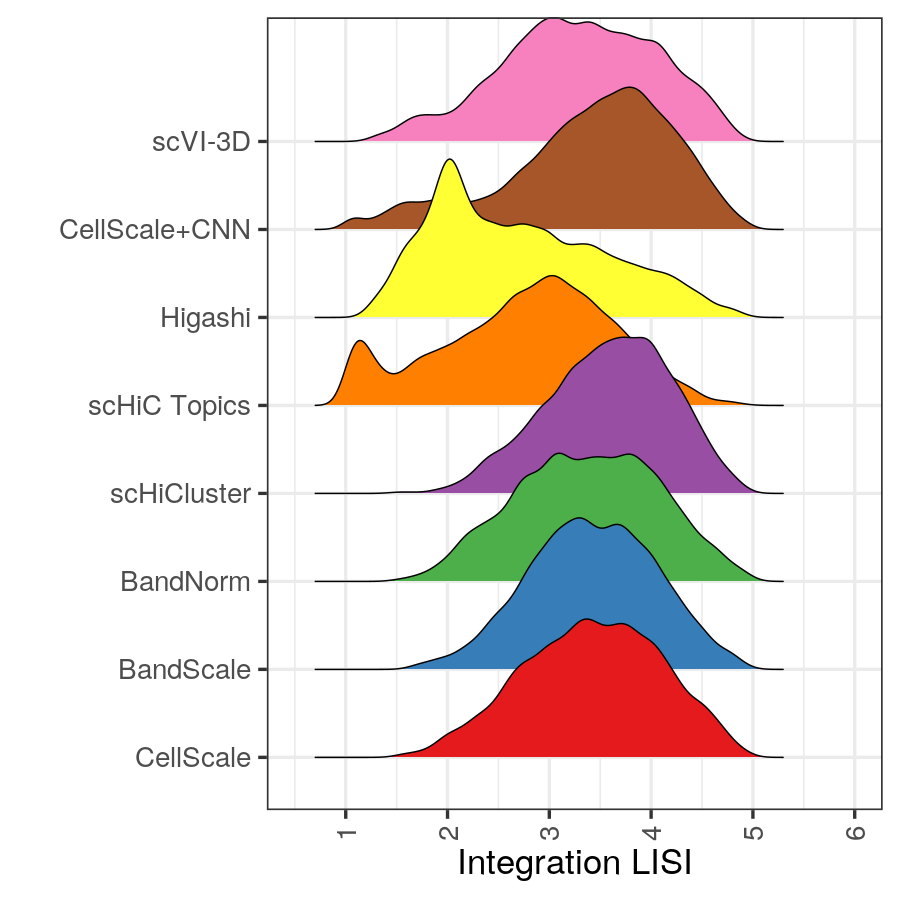

In [261]:
library(ggridges)
options(repr.plot.width = 9, repr.plot.height = 9, repr.plot.res = 100)


lisi_score$method = factor(lisi_score$method, 
                             levels = c("CellScale", "BandScale",  "BandNorm", "scHiCluster","scHiC Topics", "Higashi", "CellScale+CNN", "scVI-3D"))

lisi_score %>% ggplot(aes(x = score, y = method, fill = method)) +
geom_density_ridges(bandwidth = 0.1) +
theme_bw(base_size = 25) +
        xlab("Integration LISI") +
        ylab("") +
        ggpubr::rotate_x_text(angle = 90) +
        ggpubr::rremove("legend") +
        scale_fill_brewer(palette = "Set1") +
        ggpubr::rremove("legend.title") +
scale_x_continuous(breaks = c(0, 1, 2, 3, 4, 5, 6)) +
coord_cartesian(xlim = c(0.5, 6))
